
# Introduction

This report analyzes a dataset of private messages from an online social network at UC Irvine, containing 1899 users and 59835 messages. Each message is represented as an edge (SRC, TGT, UNIXTS), where SRC is the sender (source), TGT is the recipient (target), and UNIXTS is the Unix timestamp. Our goals are to:

- Explore and describe the dataset.
- Define and answer research questions about user activity and connectivity.
- Visualize the network, emphasizing users with high centrality.

We use Python with `pandas` for data handling, `networkx` for network analysis, and `plotly` for visualization.

# 1. Setup and Data Loading

First, make sure to correctly import all the following libraries or install them if missing. Check the README.md file for the installation guide!

In [16]:
import pandas as pd
import networkx as nx
import plotly.graph_objects as go
import nbformat
from datetime import datetime
import matplotlib.pyplot as plt

Once the above cell run correctly we can procceed by loading the dataset in `pandas` dataframe

In [17]:
# Load the dataset with columns: SRC, TGT, UNIXTS)
df = pd.read_csv('13_collegemsg_network/CollegeMsg.txt', sep=' ', header=None, names=['SRC', 'TGT', 'UNIXTS'])

# Convert UNIX timestamp to datetime
df['datetime'] = pd.to_datetime(df['UNIXTS'], unit='s', utc=True)
# Convert to local timezone Irvine (GMT-7)
df['datetime'] = df['datetime'].dt.tz_convert('America/Los_Angeles') # questo considera anche il cambio di ora legale

print(df.head()) # example of unixts vs datetime

   SRC  TGT      UNIXTS                  datetime
0    1    2  1082040961 2004-04-15 07:56:01-07:00
1    3    4  1082155839 2004-04-16 15:50:39-07:00
2    5    2  1082414391 2004-04-19 15:39:51-07:00
3    6    7  1082439619 2004-04-19 22:40:19-07:00
4    8    7  1082439756 2004-04-19 22:42:36-07:00


Unix timestamp is the number of **seconds** since 1st January 1970 and its not very readable, so we convert it to a human readable format

---

# 2. Data Exploration

Let’s explore the dataset to understand its structure and properties.

In [18]:
# Basic statistics
print("Number of messages:", len(df))
print("Time range:", df['datetime'].min(), "to", df['datetime'].max())

# Unique users
all_users = set(df['SRC']).union(set(df['TGT']))
print("Number of unique users:", len(all_users))

Number of messages: 59835
Time range: 2004-04-15 07:56:01-07:00 to 2004-10-26 00:52:22-07:00
Number of unique users: 1899


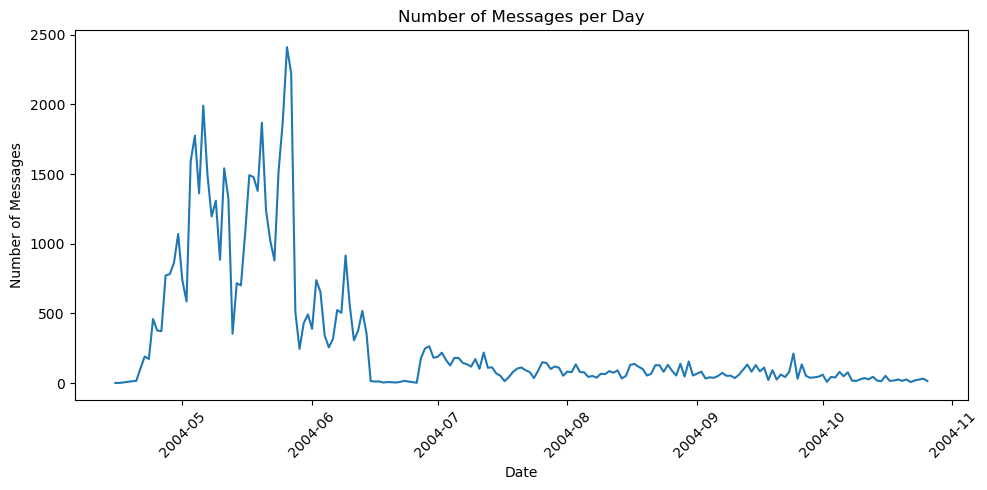

In [32]:
# Aggregate messages by date
df['date'] = df['datetime'].dt.date
messages_per_day = df.groupby('date').size().reset_index(name='count')


# print with matplotlib
plt.figure(figsize=(10, 5))
plt.plot(messages_per_day['date'], messages_per_day['count'])
plt.title('Number of Messages per Day')
plt.xlabel('Date')
plt.ylabel('Number of Messages')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()




**Output Interpretation:**
- **Number of messages:** 59835 (matches the assignment description).
- **Unique users:** 1899 (confirms the number of nodes).
- **Time range:** From the earliest timestamp (Apr 15, 2004) to the latest(Oct 26, 2004), spanning several months.
- **Messages over time:** The plot shows temporal patterns, with potential peaks indicating bursts of activity (e.g., start of semesters or events).
---

# 3. Network Construction

Build a directed graph using NetworkX, which remains unchanged since it’s independent of the plotting library.

In [20]:
# Aggregate messages by source (SRC) and target (TGT)
df_grouped = df.groupby(['SRC', 'TGT']).size().reset_index(name='count')

# Create a directed graph
G = nx.from_pandas_edgelist(df_grouped, 'SRC', 'TGT', edge_attr='count', create_using=nx.DiGraph())

# Add all users as nodes (including isolated ones)
all_users = set(df['SRC']).union(set(df['TGT']))
G.add_nodes_from(all_users)

# Basic graph statistics
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())
print("Density:", nx.density(G))

Number of nodes: 1899
Number of edges: 20296
Density: 0.005631048674611617


**Output Interpretation:**
- **Nodes:** 1899 (all users are included).
- **Edges:** Number of unique (SRC, TGT) pairs, likely less than 59835 due to aggregation (e.g., ~13800 unique directed edges).
- **Density:** Low (~0.00563), typical for sparse social networks.

---

# 4. Network Analysis

Analyze key network properties

## **Degree Distribution**
Examine the distribution of in-degrees (messages received) and out-degrees (messages sent).

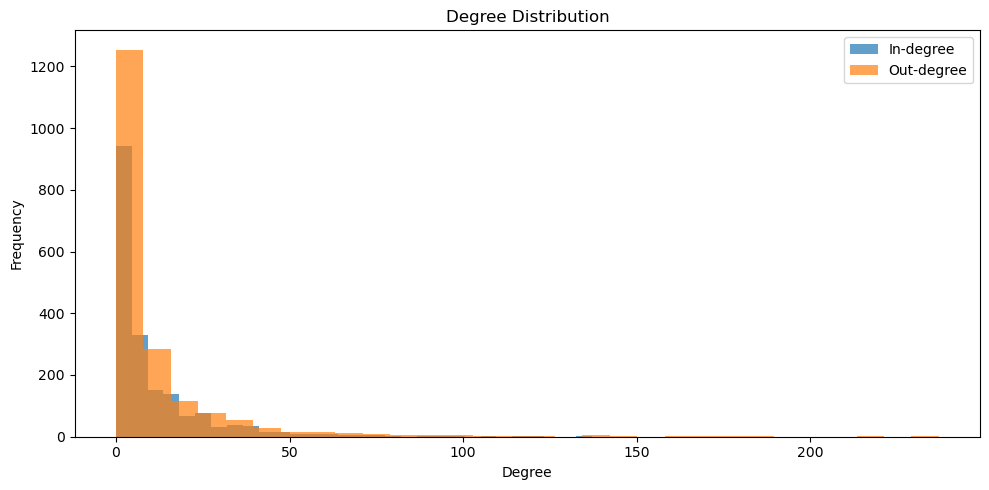

In [21]:
# Calculate degrees
in_degrees = dict(G.in_degree())
out_degrees = dict(G.out_degree())

# Plot interactive histogram
fig = go.Figure()
fig.add_trace(go.Histogram(x=list(in_degrees.values()), name='In-degree', opacity=0.7))
fig.add_trace(go.Histogram(x=list(out_degrees.values()), name='Out-degree', opacity=0.7))
fig.update_layout(
    title='Degree Distribution',
    xaxis_title='Degree',
    yaxis_title='Frequency',
    barmode='overlay'
)
# fig.show()
plt.figure(figsize=(10, 5))
plt.hist(list(in_degrees.values()), bins=30, alpha=0.7, label='In-degree')
plt.hist(list(out_degrees.values()), bins=30, alpha=0.7, label='Out-degree')
plt.title('Degree Distribution')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()


#### Isolated or One-Way Communicators

Check for users who only send or only receive messages.

In [22]:
only_senders = [node for node in G.nodes() if G.in_degree(node) == 0 and G.out_degree(node) > 0]
only_receivers = [node for node in G.nodes() if G.out_degree(node) == 0 and G.in_degree(node) > 0]
print("Users who only sent messages:", len(only_senders))
print("Users who only received messages:", len(only_receivers))

Users who only sent messages: 37
Users who only received messages: 549



**Result:** Most users have low degrees and a few have high degrees, expected in social networks.

## **Top Users**
Identify the most active users (senders and receivers).

In [23]:
# Top 5 senders (out-degree)
top_out = sorted(out_degrees.items(), key=lambda x: x[1], reverse=True)[:5]
print("Top 5 users by out-degree (sent messages):")
for user, degree in top_out:
    print(user, degree)

# Top 5 receivers (in-degree)
top_in = sorted(in_degrees.items(), key=lambda x: x[1], reverse=True)[:5]
print("\nTop 5 users by in-degree (received messages):")
for user, degree in top_in:
    print(user, degree)

Top 5 users by out-degree (sent messages):
9 237
103 233
105 219
400 217
32 182

Top 5 users by in-degree (received messages):
32 137
42 120
638 119
372 115
598 115


## **Centrality**
Compute PageRank to find influential users.

In [24]:
pagerank = nx.pagerank(G)
top_pagerank = sorted(pagerank.items(), key=lambda x: x[1], reverse=True)[:5]
print("Top 5 users by PageRank:")
for user, pr in top_pagerank:
    print(user, pr)

Top 5 users by PageRank:
32 0.00599751428212459
42 0.005897543015508085
638 0.005389242638293345
372 0.005086009601527967
400 0.004538513498373943


**Osservation**: We can already see that then the users who got the most mesages (in-degree) are not all the once that made it in the top of the PageRank list.

#### Reciprocity

Measure the proportion of reciprocal edges.

In [25]:
reciprocal_edges = [(u, v) for u, v in G.edges() if G.has_edge(v, u)]
print("Proportion of reciprocal edges:", len(reciprocal_edges) / G.number_of_edges())

Proportion of reciprocal edges: 0.6363815530153725


**Result:** 63% of edges are reciprocal, indicating moderate two-way communication.


**Result:** Dense graph where central nodes (larger) stand out, but it’s cluttered due to 1899 nodes.

## **Subgraph of Central Nodes**
Focus on nodes with an in-degree ≥ 10 for a clearer view.

In [26]:
# Select central nodes (in-degree >= 10)
threshold = 10
sub_nodes = [node for node, deg in in_degrees.items() if deg >= threshold]
sub_G = G.subgraph(sub_nodes)

# Generate positions
pos_sub = nx.spring_layout(sub_G)

# Edge trace
edge_x_sub = []
edge_y_sub = []
for edge in sub_G.edges():
    x0, y0 = pos_sub[edge[0]]
    x1, y1 = pos_sub[edge[1]]
    edge_x_sub.extend([x0, x1, None])
    edge_y_sub.extend([y0, y1, None])

edge_trace_sub = go.Scatter(
    x=edge_x_sub, y=edge_y_sub,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines'
)

# Node trace with size based on in-degree
node_x_sub = [pos_sub[node][0] for node in sub_G.nodes()]
node_y_sub = [pos_sub[node][1] for node in sub_G.nodes()]
node_sizes_sub = [in_degrees.get(node, 0) for node in sub_G.nodes()]

node_trace_sub = go.Scatter(
    x=node_x_sub, y=node_y_sub,
    mode='markers',
    hoverinfo='text',
    text=[f'Node: {node}<br>In-degree: {in_degrees[node]}' for node in sub_G.nodes()],
    marker=dict(
        size=[size * 2 for size in node_sizes_sub],  # Scale for visibility
        color=node_sizes_sub,
        colorscale='YlGnBu',
        showscale=True,
        colorbar=dict(thickness=15, title='In-degree'),
        line_width=2
    )
)

# Create and show figure
fig_sub = go.Figure(data=[edge_trace_sub, node_trace_sub],
                    layout=go.Layout(
                        title='Subgraph (In-Degree ≥ 10)',
                        showlegend=False,
                        hovermode='closest',
                        margin=dict(b=20, l=5, r=5, t=40),
                        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)
                    ))
# fig_sub.show()
fig_sub.write_html('Images/subgraph.html')
# fig_sub.write_image('Images/subgraph.png')

# open link
import webbrowser
webbrowser.open('Images/subgraph.html') 

True

# 6. Temporal Analysis

With pandas we can take advantage of the datetime functionalities to analyze the data in a more human readable way. E.g. by weekday, month, and hour.


## Messages by different time periods

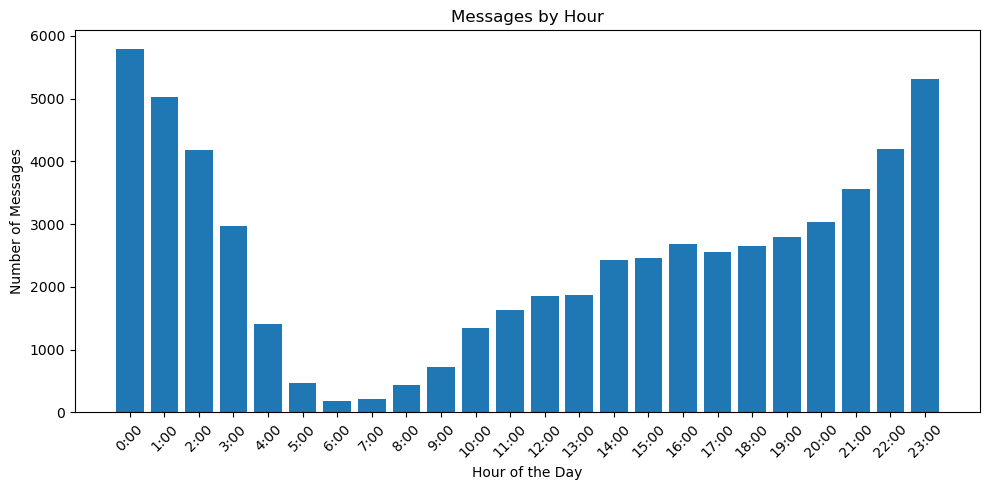

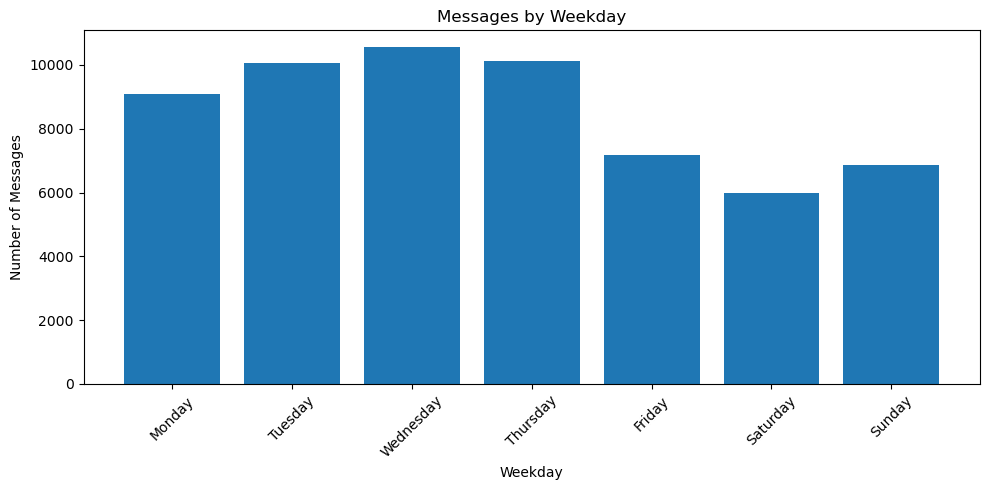

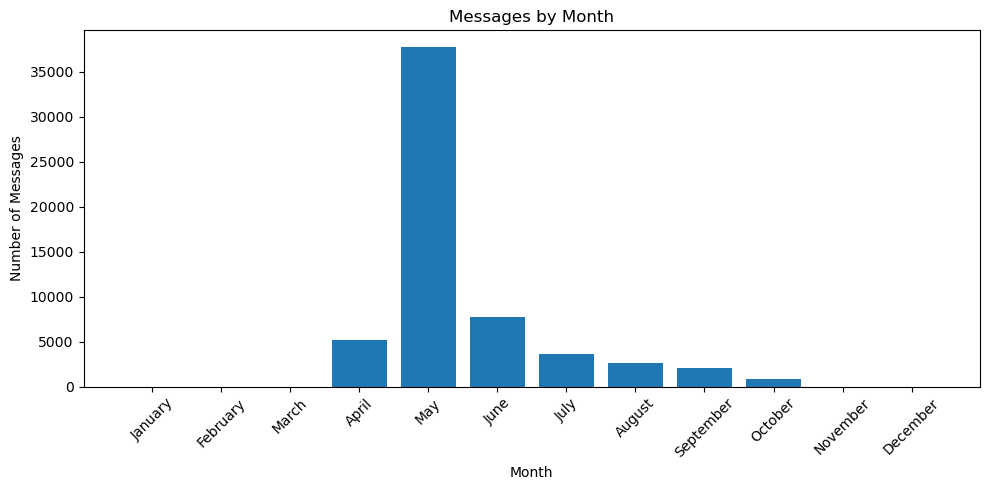

In [ ]:
# Add a new column with the weekday
df['weekday'] = df['datetime'].dt.weekday
weekday_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_counts = df['weekday'].value_counts().reindex(range(7)).fillna(0)


# Add a new column with the hour
df['hour'] = df['datetime'].dt.hour 
hour_counts = df['hour'].value_counts().reindex(range(24)).fillna(0)

# with matplotlib
plt.figure(figsize=(10, 5))
plt.bar(range(24), hour_counts)
plt.title('Messages by Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Messages')
plt.xticks(rotation=45)
plt.xticks(range(24), [f'{i}:00' for i in range(24)])
plt.tight_layout()
plt.show()


# with matplotlib
plt.figure(figsize=(10, 5))
plt.bar(weekday_names, weekday_counts)
plt.title('Messages by Weekday')
plt.xlabel('Weekday')
plt.ylabel('Number of Messages')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



# Add a new column with the month
df['month'] = df['datetime'].dt.month
month_names = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
month_counts = df['month'].value_counts().reindex(range(1, 13)).fillna(0)

# with matplotlib
plt.figure(figsize=(10, 5))
plt.bar(month_names, month_counts)
plt.title('Messages by Month')
plt.xlabel('Month')
plt.ylabel('Number of Messages')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Top 5 user analysis

        SRC   TGT      UNIXTS                  datetime        date  weekday  \
948     166   234  1082872216 2004-04-24 22:50:16-07:00  2004-04-24        5   
3267    234   166  1083222313 2004-04-29 00:05:13-07:00  2004-04-29        3   
3700    234   391  1083241257 2004-04-29 05:20:57-07:00  2004-04-29        3   
3721    297   234  1083263529 2004-04-29 11:32:09-07:00  2004-04-29        3   
3835    391   234  1083284623 2004-04-29 17:23:43-07:00  2004-04-29        3   
...     ...   ...         ...                       ...         ...      ...   
58944   234  1624  1096445591 2004-09-29 01:13:11-07:00  2004-09-29        2   
58956  1624   234  1096484960 2004-09-29 12:09:20-07:00  2004-09-29        2   
58957  1624   234  1096485028 2004-09-29 12:10:28-07:00  2004-09-29        2   
59018   234   642  1096602031 2004-09-30 20:40:31-07:00  2004-09-30        3   
59069   642   234  1096678623 2004-10-01 17:57:03-07:00  2004-10-01        4   

       month  hour  
948        4    22

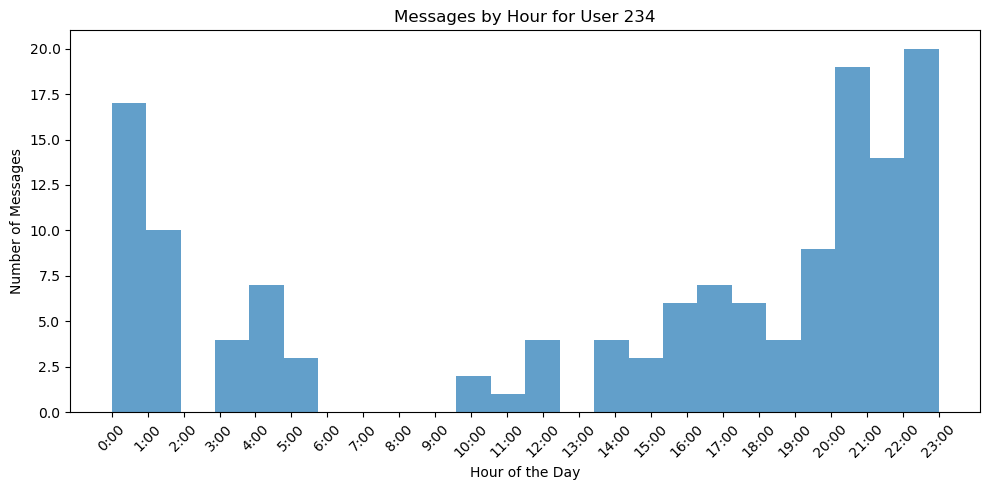

In [29]:

# select first user
user = 234
# Select messages from the user
user_messages = df[(df['SRC'] == user) | (df['TGT'] == user)]
# user_messages_by_hour = user_messages['datetime'].dt.hour
print(user_messages)

user_messages_by_hour = user_messages['datetime'].dt.hour

plt.figure(figsize=(10, 5))
plt.hist(user_messages_by_hour, bins=24, alpha=0.7)
plt.title(f'Messages by Hour for User {user}')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Messages')
plt.xticks(rotation=45)
plt.xticks(range(24), [f'{i}:00' for i in range(24)])
plt.tight_layout()
plt.show()


**Result:** Peaks in activity (e.g., mid-2004) may correlate with social events or network usage spikes.

---

